## MLOPs exercises

 
## 1. Task 1 Create a function that preprocess new ames data in the same way as the original ames data was preprocessed in step 5 in the `MLOps.ipynb` notebook.

In [1]:
#import Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#Preprocess Function
def preprocess_input(input):
    """
        Preprocess the Ames Housing Dataset and creates dummy variables for the Bldg Type and Neighborhood columns
    """
    df = input[["Lot Area", "Overall Cond", "Year Built", "Gr Liv Area", "TotRms AbvGrd", "Mo Sold", "Yr Sold", "Bldg Type", "Neighborhood", "SalePrice"]]
    #Create Dummy Variables for the Building Type
    df = df.join(pd.get_dummies(df["Bldg Type"], drop_first=True, dtype=int, prefix="BType:"))
    
    #Create Dummy Variables for the Neighborhood
    df = df.join(pd.get_dummies(df["Neighborhood"], drop_first=True, dtype=int, prefix="Nbh:"))

    #Drop the original columns
    df = df.drop(columns=["Bldg Type", "Neighborhood"])

    return df

## 2.Create a function that takes as input a new ames dataset and a model. The function should pre-process the new data and evaluate the model on that new data using mean absolute error.

In [3]:
#Import Libraries
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.metrics import  mean_absolute_error, mean_squared_error

In [4]:
#Function to evaluate the date
def evaluate_new_data(input_data, model):
    """
        Evaluate the model on new data

        Returns:
            mae
    """

    
    df = preprocess_input(input_data)

    #Separate the features and the target
    X_ames = df.drop(columns=["SalePrice"])
    y_ames = df["SalePrice"]

    #Train-test split the data
    X_train, X_test, y_train, y_test = train_test_split(X_ames, y_ames, test_size=0.2, random_state=42)

    #Train-Validate training data
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)

    return mae

## 3.Test the function from 2. on the "NewAmesData1.csv" dataset and the best model from the `MLOps.ipynb` notebook.

In [5]:
#Load new data
new_data_1 = pd.read_csv("Datasets/NewAmesData1.csv")

In [6]:
#Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

In [7]:
#Evaluate the model
model = GradientBoostingRegressor()
mae_GradientBoosting = evaluate_new_data(new_data_1, model)
print(f"MAE for Gradient Boosting on NewAmesData1: {mae_GradientBoosting}")

MAE for Gradient Boosting on NewAmesData1: 24525.92684233447


## 4. Test the function from 2. on the "NewAmesData2.csv" dataset and the best model from the `MLOps.ipynb` notebook. Do you see any drift?

In [8]:
#Load new data
new_data_2 = pd.read_csv("Datasets/NewAmesData2.csv")

In [9]:
#Evaluate the model
model = GradientBoostingRegressor()
mae_GradientBoosting = evaluate_new_data(new_data_2, model)
print(f"MAE for Gradient Boosting on NewAmesData2: {mae_GradientBoosting}")

MAE for Gradient Boosting on NewAmesData2: 53876.18080462256


## 5. Do you see a data drift in "NewAmesData2.csv"? If so, for which variables?

From a first glimpse we see that our model's MAE has doubled on the new dataset which indicates Concept drifting. The relationship between the features and the target has changed.

Let explore which variables cause the a change in the underlying pattern and the model is seeing different type of input than what is was trained on.
We are examining in two ways.
1. PLotting the distributions of fetures for the two datasets
2. Using Kolmogorov-Smirnov to compare the feature distributions.

In [10]:
ames_1 = preprocess_input(new_data_1)
ames_2 = preprocess_input(new_data_2)

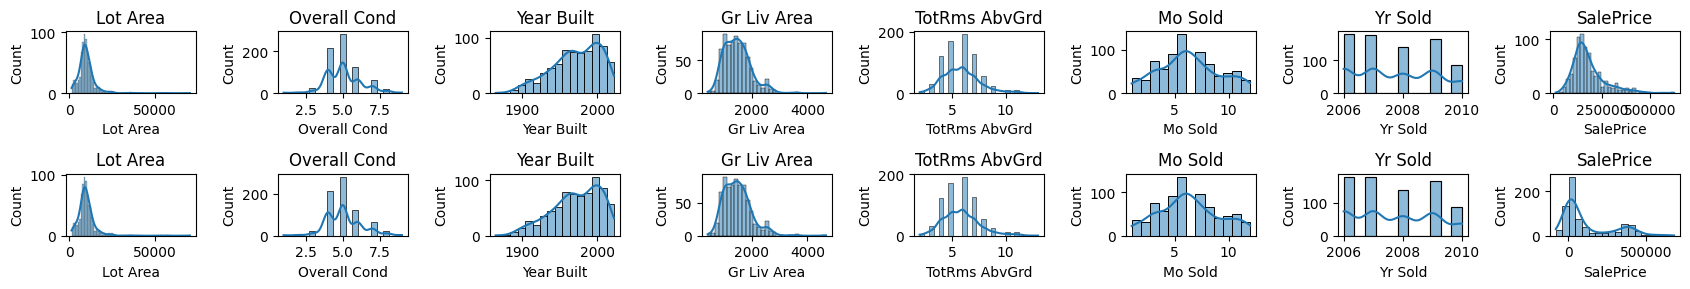

In [11]:
# Create subplots with a 2x7 grid
fig, axes = plt.subplots(2, 8, figsize=(17, 3))  # Adjusted figsize

# Plot each column as a histogram
for i, column in enumerate(ames_1.columns[:8]):
    sns.histplot(ames_1[column], ax=axes[0,i], kde=True)
    axes[0,i].set_title(column)
for i, column in enumerate(ames_2.columns[:8]):
    sns.histplot(ames_2[column], ax=axes[1,i], kde=True)
    axes[1,i].set_title(column)

plt.tight_layout()
plt.show()

From the plot we can cleary see that the distribution of SalePrice has change, which indicates Label Drift. Meaning our model needs to be retrained.
But lets verify it with Kolmogorov-Smirnov.

In [12]:
#Kolmogorov-Smirnov
from scipy.stats import ks_2samp

for column in new_data_1.columns:
    stat, p_value = ks_2samp(new_data_1[column], new_data_2[column])
    if p_value < 0.05:
        print(f"Feature {column} has changed (p={p_value:.3f})")

Feature SalePrice has changed (p=0.000)


## 6. Do you see a data drift in "NewAmesData4.csv"? If so, for which variables?

In [13]:
#Load new data
new_data_4 = pd.read_csv("Datasets/NewAmesData4.csv")

In [14]:
#Evaluate the model
model = GradientBoostingRegressor()
mae_GradientBoosting = evaluate_new_data(new_data_4, model)
print(f"MAE for Gradient Boosting on NewAmesData2: {mae_GradientBoosting}")

MAE for Gradient Boosting on NewAmesData2: 25897.453755432376


The mae Results for the Ames1 and Ames4 are pretty close, eventhough they suggest a Concept Drift.
 There is huge difference with Ames2 but probably for the same reasons as the previous analysis.

Let analyze ames1 and ames4

In [15]:
ames_4 = preprocess_input(new_data_2)

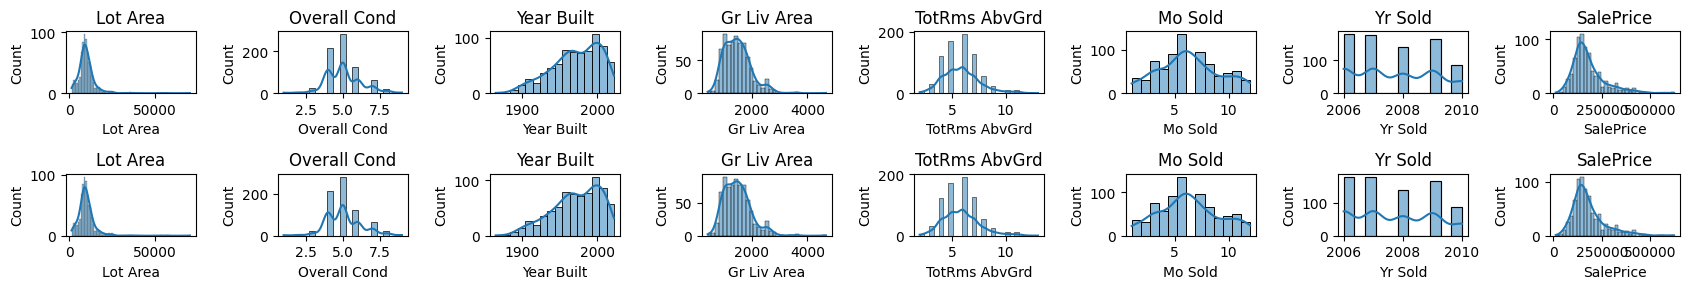

In [16]:
#Plot the two dataset
# Create subplots with a 2x7 grid
fig, axes = plt.subplots(2, 8, figsize=(17, 3))  

# Plot each column as a histogram
for i, column in enumerate(ames_1.columns[:8]):
    sns.histplot(ames_1[column], ax=axes[0,i], kde=True)
    axes[0,i].set_title(column)
for i, column in enumerate(ames_4.columns[:8]):
    sns.histplot(ames_1[column], ax=axes[1,i], kde=True)
    axes[1,i].set_title(column)

plt.tight_layout()
plt.show()

We cant see a clear  difference in the distribution of feaures. Lets perform K-S test.

In [17]:
#Kolmogorov-Smirnov
for column in new_data_1.columns:
    stat, p_value = ks_2samp(new_data_1[column], new_data_2[column])
    if p_value < 0.05:
        print(f"Feature {column} has changed (p={p_value:.3f})")

Feature SalePrice has changed (p=0.000)


Even though we can spot the difference from the plot the k-S suggest that there is a differece. Hence there is potentially label drift.

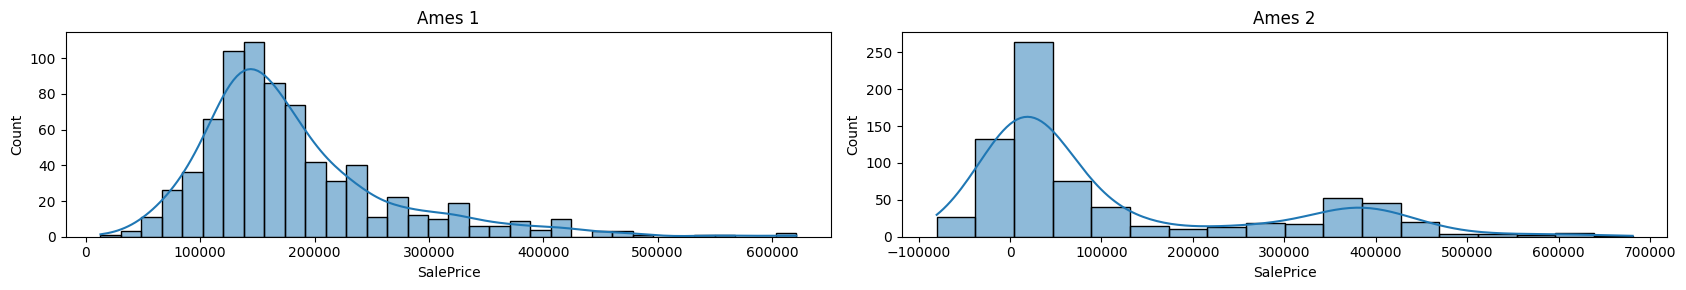

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(17, 3)) 
sns.histplot(data=ames_1, x="SalePrice", kde=True, ax=axes[0])
sns.histplot(data=ames_2, x="SalePrice", kde=True, ax=axes[1])
axes[0].set_title("Ames 1")
axes[1].set_title("Ames 2")
plt.tight_layout()
plt.show()
plt.show()

On a closer look it look like there is indead a differnce.